# Sample Code to Deal with World Pop Data in Google Earth Engine

You'll need an account with Google Earth Engine and a Google Cloud Platform project to run this code. You can sign up for Google Earth Engine at https://earthengine.google.com/signup/ and create a project at https://console.cloud.google.com/. You'll also need to enable the Earth Engine API for your project. This code also uses geemap, a Python package for interactive mapping and data download/uploads with Earth Engine. Installation instructions for geemap are at https://geemap.org/installation/.

### Setup Code
Import libraries, authenticate with GEE

In [15]:
# import libraries
import ee
import geemap

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

### Import and Visualize WorldPop Data

In [4]:
# fetch entire worldpop image collection on the ee server
worldpop = ee.ImageCollection("WorldPop/GP/100m/pop")

In [5]:
# get worldpop images from the country Sierra Leone
worldpop_sl = worldpop.filter(ee.Filter.eq('country', 'SLE'))

# print the worldpop_sl image collection
worldpop_sl

In [8]:
# filter the worldpop_sl image collection to get the image for the year 2020
worldpop_sl_2020 = worldpop_sl.filter(ee.Filter.eq('year', 2020)).first()

# print the worldpop_sl_2020 image variable
worldpop_sl_2020

In [13]:
# create map
m = geemap.Map()

# define visualization parameters
vis_params = {
    'bands': ['population'],
    'min': 0.0,
    'max': 10.0,
    'palette': ['24126c', '1fff4f', 'd4ff50']
}
# add worldpop image to map
m.addLayer(worldpop_sl_2020, vis_params, 'WorldPop Sierra Leone')

# center map on Sierra Leone
m.centerObject(worldpop_sl_2020, 8)

# print map
m


Map(center=[8.457738986496633, -11.78458322613133], controls=(WidgetControl(options=['position', 'transparent_…

### Import CBIL Mini-Grid Sites

In [16]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

### Convert CSV from Daily Meter Summary Logs into a GeoDataFrame

In [61]:
# read in site_data.csv for CBIL with longitude and latitude columns
cbil_df = pd.read_csv('../data/cbil/site_data.csv')
# create a geometry column
geometry = [Point(xy) for xy in zip(cbil_df['metadata.project.longitude'], cbil_df['metadata.project.latitude'])]
# replace periods in column names
cbil_df.columns = cbil_df.columns.str.replace('.', '')
# create a geodataframe
cbil_gdf = gpd.GeoDataFrame(cbil_df, crs='EPSG:4326', geometry=geometry)
# export geodataframe to geojson file
cbil_gdf.to_file('../data/cbil/cbil_sites.geojson', driver='GeoJSON')

### Convert GeoDataFrame to GEE Feature Collection & Visualize

In [62]:
# read in the geodataframe from the csv
cbil_gdf = gpd.read_file('../data/cbil/cbil_sites.geojson')

# convert the geodataframe to an ee feature collection
cbil_fc = geemap.geopandas_to_ee(cbil_gdf)

# filter for just sites in the feature collection in Sierra Leone
cbil_sl_fc = cbil_fc.filter(ee.Filter.eq('country', 'Sierra Leone'))

# add the geodataframe to the map in purple
m.addLayer(cbil_sl_fc, {'color': 'ff00ff'}, 'CBIL Sites')

# check out the map above, the points should appear now in purple

### Calculate the Population within a 1km Buffer of Each Mini-Grid Site for All Years

In [38]:
# convert each point into a circle with a 1km radius
# get a feature collection of polygons instead of points.
cbil_sl_buffer_fc = cbil_sl_fc.map(lambda feature: feature.buffer(1000))

# convert the worldpop_sl image collection into a single image with one band for each year
worldpop_sl = worldpop_sl.select('population')
worldpop_sl_stack = worldpop_sl.toBands()

# we can use the reduceRegions function to calculate the sum of the population within each buffer
# calculate the sum of the population within each buffer for every image "band"
cbil_sl_pop_fc = worldpop_sl_stack.reduceRegions(
    collection=cbil_sl_buffer_fc,
    reducer=ee.Reducer.sum(),
)

# convert the cicular buffers back to points
cbil_sl_pop_fc = cbil_sl_pop_fc.map(lambda feature: feature.centroid())

### Convert back to GeoDataFrame and Export to CSV

In [ ]:
# export the feature collection to a geopandas dataframe
cbil_sl_pop_gdf = geemap.ee_to_geopandas(cbil_sl_pop_fc)

# export the geopandas dataframe to a csv file
cbil_sl_pop_gdf.to_csv('../data/cbil/cbil_sites_population.csv', index=False)

### Convert the Pivot Table into a Melted Dataframe with 1 Observation per Row

In [51]:
# read in the csv
df = pd.read_csv('../data/cbil/cbil_sites_population.csv')

# replace all column names containing 'SLE_' with ''
df.columns = df.columns.str.replace('SLE_', '')
df.columns = df.columns.str.replace('_population', '')

# rename metadataprojectcod to date_commissioned, convert to datetime
df = df.rename(columns={'metadataprojectcod': 'date_commissioned'})
df['date_commissioned'] = pd.to_datetime(df['date_commissioned'])

# rename metadataprojectlatitude to latitude
df = df.rename(columns={'metadataprojectlatitude': 'latitude'})
df = df.rename(columns={'metadataprojectlongitude': 'longitude'})

# drop extra columns
df = df.drop(columns=['country', 'data_source', 'developer', 'geometry', 'metadataprojectstatus', 'site_id_odyssey'])

# melt the dataframe
df = df.melt(id_vars=['site', 'date_commissioned', 'latitude', 'longitude'], var_name='year', value_name='population')

# round the population column to integers
df['population'] = df['population'].round().astype(int)

# convert the year column to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

# export the dataframe to a csv
df.to_csv('../data/cbil/cbil_sites_population_melt.csv', index=False)

### Visualize the Results

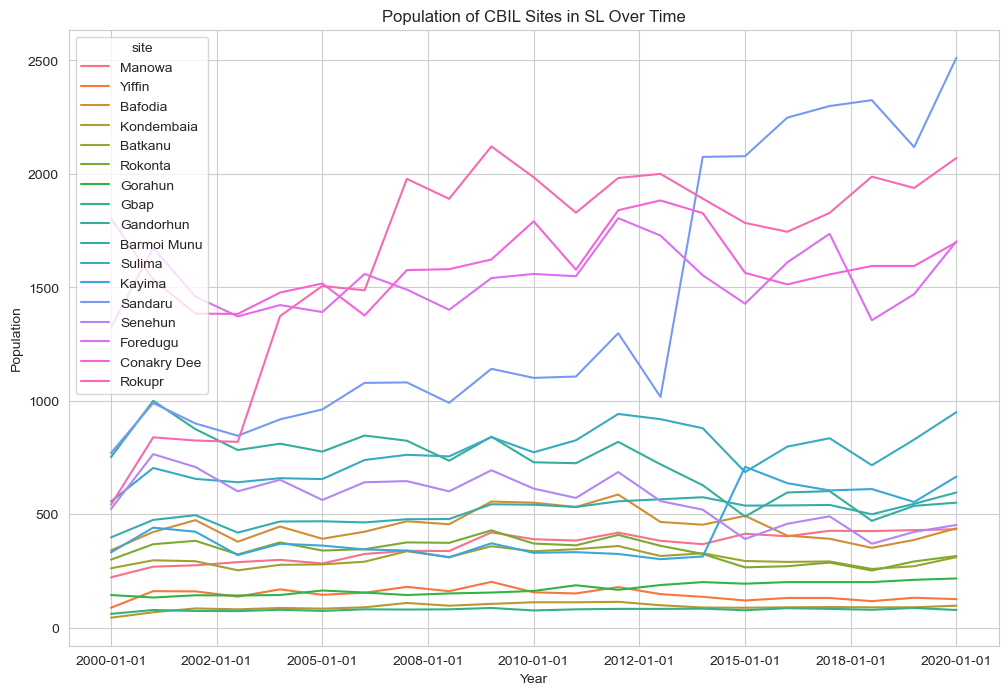

In [58]:
# import the melted dataframe
df = pd.read_csv('../data/cbil/cbil_sites_population_melt.csv')

# plot the population of each site over time
import matplotlib.pyplot as plt
import seaborn as sns

# set the style
sns.set_style('whitegrid')

# create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# plot the population of each site over time
sns.lineplot(data=df, x='year', y='population', hue='site', ax=ax)

# set the title
ax.set_title('Population of CBIL Sites in SL Over Time')

# set the x-axis label
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# set the y-axis label
ax.set_ylabel('Population')

# show the plot
plt.show()